In [1]:
import warnings
warnings.filterwarnings(action='once')

from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from scipy.stats import boxcox
from sklearn import metrics # for the check the error and accuracy of the model

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [3]:
#reading and concatinating customer data

raw_1 = pd.read_excel('D:/UK/assignment/DSA8023/WB1_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_2 = pd.read_excel('D:/UK/assignment/DSA8023/WB2_Energia_Challenge_March_2023_Data.xlsx', sheet_name=1)
raw_d = pd.concat([raw_1, raw_2])

In [64]:
# Defining constants

billing_months = ['bill_1_2021', 'bill_2_2021',
       'bill_3_2021', 'bill_4_2021', 'bill_5_2021', 'bill_6_2021',
       'bill_1_2022', 'bill_2_2022', 'bill_3_2022', 'bill_4_2022',
       'bill_5_2022', 'bill_6_2022', 'bill_1_2023']

categorical_columns = ['title', 'mosaicType', 'agedBand', 'saStatus', 'signedUpGroup']

# based on the fact that ifn one reading is missed for a particular month, the reading will be accumulated to next month.
# the reading is averaged between missing and accumulated months.
# only one missed month is accepted thus eleminating rows with consecutive zeros
# end result will have no zero readings
def average_missing_months(x):
    for index, month in enumerate(billing_months[:-1]):
        next_month = billing_months[index+1]
        if x[month] == 0:
            if(x[next_month] != 0):
                x[month] = x[next_month] / 2
                x[next_month] = x[next_month] / 2
            else:
                break
    return x

def checkCateoricalInfo(data, cols):
    for col in cols:
        unique = data[col].unique()
        print('{}({}) - {}'.format(col, len(unique), unique));
        print()


In [65]:
df = raw_d.copy()

checkCateoricalInfo(df, categorical_columns)

le = LabelEncoder()
 
# keeping nan values in title, agedband as they have relatively less effect on EV classification
df['title'] = le.fit_transform(df['title'])
df['mosaicType'] = le.fit_transform(df['mosaicType'])
df['agedBand'] = le.fit_transform(df['agedBand'])
df['signedUpGroup'] = le.fit_transform(df['signedUpGroup'])
df['saStatus'] = le.fit_transform(df['saStatus'])


# manually assigning numeric values to EV related categories
rename_props = { 'EV': {'N': 0, 'Y': 1},
                  'EV_New_or_Old': {'Non-EV Customers': 0, 'Switched to EV': 1, 'New EV Customer': 1}} 

df = df.replace(rename_props)


title(10) - ['Mr' 'Ms' 'Mrs' ' ' 'Miss' 'Dr' 'Mr & Mrs' nan 'Rev' 'Cllr']

mosaicType(44) - [nan 'F17' 'G18' 'K31' 'M37' 'G19' 'N42' 'L33' 'B04' 'C09' 'M38' 'E14'
 'B06' 'A03' 'J29' 'A02' 'C07' 'F15' 'N43' 'H22' 'K30' 'C08' 'J28' 'L35'
 'E13' 'B05' 'J26' 'N40' 'A01' 'H23' 'K32' 'D10' 'N41' 'G20' 'I24' 'M39'
 'F16' 'D11' 'J27' 'L34' 'H21' 'L36' 'I25' 'D12']

agedBand(9) - ['41 to 50' 'Unclassified' '51 to 60' '61 to 70' '25 to 40' '70+'
 '19 to 24' nan '18 & Under']

saStatus(1) - ['Active']

signedUpGroup(6) - ['PCW' 'Telesales' 'Other' 'Web' 'Field Sales' 'OBS']



In [66]:
def visualizeFeatureCount(dataset, feature = 'EV'):
    totalData = len(dataset)
    hasFeature = dataset[feature].sum()
    
#     print(totalData, has)
    hasNoFeature = totalData - hasFeature

    hasFeature_per = round(hasFeature/totalData * 100, 2)
    hasNoFeature_per = round(hasNoFeature/totalData * 100, 2)

    plt.figure()
    sns.countplot(data = dataset, x=feature)
    plt.annotate('No {}: {}'.format(feature, hasNoFeature), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
    plt.annotate('{}: {}'.format(feature, hasFeature), xy=(0.7, 15000), xytext=(0.9, 3000), size=12)
    plt.annotate(str(hasNoFeature_per)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
    plt.annotate(str(hasFeature_per)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
    plt.show()

def plot_hist_plots(t_data, t_features, fig_size= 8):
    f = plt.figure(figsize=(fig_size,fig_size))
    for i, feature in enumerate(t_features):
        t = f.add_subplot(round(len(t_features)/3) + 1,3, i+1)
        sns.histplot(t_data[feature])
        t.title.set_text(feature)
    plt.show();

def plot_corr_plot(ds):
    corr = ds.corr(numeric_only=True) # .corr is used to find corelation
    f,ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
                xticklabels= True, yticklabels= True
                ,cmap="coolwarm", linewidths=.5, ax=ax)
    plt.title('CORRELATION MATRIX - HEATMAP', size=18);
    
def predict_and_visualize(model, dataset, class_col, class_col_predicted= 'EV_predicted'):
    
    x = df.copy()
    feature = df[class_col]

    x= x.drop(columns=[class_col])
    x[class_col_predicted] = model.predict(x)
    x[class_col] = feature
    visualizeFeatureCount(x, feature='EV_predicted')
    print(x.shape)
    


In [67]:
df = df.apply(average_missing_months, axis=1)

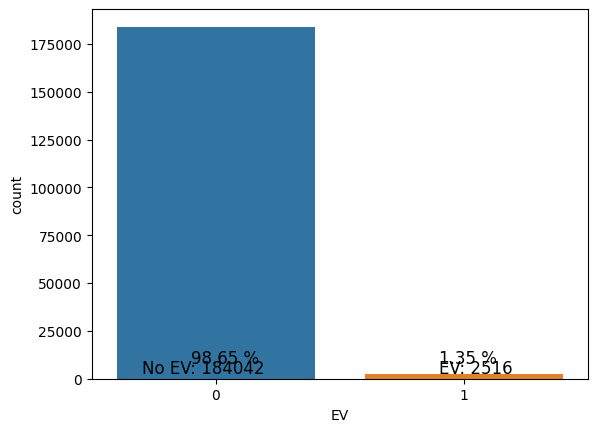

In [171]:

# initial data cleaning

is_zero_bill_value_allowed = False

# deleting date related 
cols_to_delete = ['StartDate','ContractStartDateEV','contractStartDate','contractEndDate','saStatus', 'accountID', 'title']
if df.columns.isin(cols_to_delete).any():
    df = df.drop(columns=cols_to_delete)

if is_zero_bill_value_allowed:
    df['zero_count'] = df[billing_months].isin([0]).sum(axis=1)
    cleaned_data = df.copy()
else:
    cleaned_data = df[~df[billing_months].isin([0]).any(axis=1)]



visualizeFeatureCount(df)    

In [69]:
# plot heat map of correlation features
# plot_corr_plot(cleaned_data)

In [70]:
# check distribution of billing features before transforming
# plot_hist_plots(cleaned_data, cleaned_data.columns, fig_size=12)


In [71]:
# ignore - Applying log transformation to fix right skewness in billing period distribution
# sqrt_t_data = cleaned_data.copy()

# for month in billing_months:
#     sqrt_t_data[month] = np.sqrt(sqrt_t_data[month])

# plot_hist_plots(sqrt_t_data, billing_months)

In [168]:
# perform logistic regression

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


def perform_sampling(x_train, y_train, y_test, sampling):
    print('Training set: {}'.format(Counter(y_train)))
    print('Testing set: {}'.format(Counter(y_test)))
    
    if sampling == 'under':
        from imblearn.under_sampling import NearMiss 
        sampler = NearMiss(version=1, n_neighbors=3)
    elif sampling == 'over':
        from imblearn.over_sampling import SMOTE 
        sampler = SMOTE(random_state=42)

    x_train, y_train = sampler.fit_resample(x_train, y_train)
    print('Training set: {}'.format(Counter(y_train)))
    print('Testing set: {}'.format(Counter(y_test)))
    
    return x_train, y_train

@ignore_warnings(category=ConvergenceWarning)
def perform_logistic_reg(data, class_col, sampling=None, solver='lbfgs'):
    x = data.drop(class_col, axis=1)  
    y = data[class_col]

    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
    
    if sampling:
        X_train, y_train = perform_sampling(X_train, y_train,y_test,  sampling)

    LR = LogisticRegression(C=0.00005, random_state=0, solver=solver)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    get_metrics(y_pred, X_test, y_test, LR, x, y, sampling)
    return LR

def get_metrics(y_pred, X_test, y_test, LR, x, y, sampling = None):
    ## 5-fold cross-validation 
    cv_scores =cross_val_score(LR, x, y, cv=5)

    # Print the 5-fold cross-validation scores
    print()
    print(classification_report(y_test, y_pred))
    print()
    print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
          ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

    plt.figure(figsize=(4,3))
    ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
                xticklabels = ['No EV', 'EV'], 
                yticklabels = ['No EV', 'EV'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix - Logistic Regression - {}".format(sampling));
    
    total1=sum(sum(ConfMatrix))
    #####from confusion matrix calculate accuracy
    
    print('Accuracy:', metrics.accuracy_score(y_pred,y_test))
    sensitivity = ConfMatrix[0,0]/(ConfMatrix[0,0]+ConfMatrix[0,1])
    print('Sensitivity : ', sensitivity )
    specificity = ConfMatrix[1,1]/(ConfMatrix[1,0]+ConfMatrix[1,1])
    print('Specificity : ', specificity)

Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 77553, 1: 77553})
Testing set: Counter({0: 19389, 1: 212})
Accuracy: 0.8001632569766849

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     19389
           1       0.04      0.72      0.07       212

    accuracy                           0.80     19601
   macro avg       0.52      0.76      0.48     19601
weighted avg       0.99      0.80      0.88     19601


Average 5-Fold CV Score: 0.9887 , Standard deviation: 0.0002
Sensitivity :  0.8010211975862602
Specificity :  0.7216981132075472


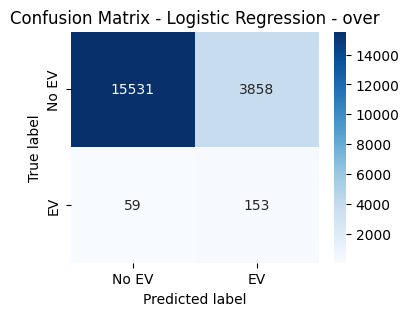

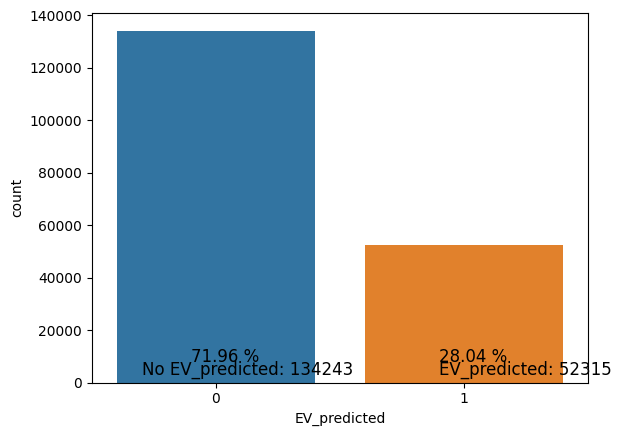

(186558, 19)


In [122]:
LR2 = perform_logistic_reg(cleaned_data, class_col='EV', sampling='over')
predict_and_visualize(LR2,df,  'EV')

In [143]:
# # anayzing with scaled data and perform LR
# def scale_data_standard_scaler(data, feature_cols):
#     scaled_data = data.copy()
#     features = scaled_data[feature_cols]
#     scaler = StandardScaler().fit(features.values)
#     features = scaler.transform(features.values)
#     scaled_data[feature_cols] = features
#     return scaled_data

# scaled_data = scale_data_standard_scaler(cleaned_data, billing_months)
# LR4 = perform_logistic_reg(scaled_data, class_col='EV' )
# predict_and_visualize(LR4,df,  'EV')

In [125]:
# Perform RFE and find important features 

@ignore_warnings(category=ConvergenceWarning)
def perform_RFE(dataset, class_col='EV'):
    test_df_1 = dataset.copy()

    x = test_df_1.drop(class_col, axis=1)  
    y = test_df_1[class_col]

    model = LogisticRegression()
    rfe_stand = RFE(model, n_features_to_select = 9 )
    fit_stand = rfe_stand.fit(x, y)
    print("St Model Num Features:", fit_stand.n_features_)
    #print("St Model Selected Features:", fit_stand.support_)
    print("Std Model Feature Ranking:", fit_stand.ranking_)
    # calculate the score for the selected features
    score_stand = rfe_stand.score(x,y)
#     print("Standardized Model Score with selected features is: %f (%f)" % (score_stand.mean(), score_stand.std()))
    feature_names = np.array(x.columns)
    print('Most important features (RFE): %s'% feature_names[rfe_stand.support_])
    
    return feature_names[rfe_stand.support_]

In [160]:
## Analysing important features with RFE

# RFE_data = cleaned_data.copy()
# # RFE_data = scale_data_standard_scaler(RFE_data, billing_months)

# imp_cols = perform_RFE(RFE_data)

# imp_data = RFE_data[imp_cols]
# imp_data['EV'] = cleaned_data['EV'].to_numpy()
# imp_LR = perform_logistic_reg(imp_data, class_col='EV')
# predict_and_visualize(imp_LR,df[[imp_cols]],  'EV')

Training set: Counter({0: 77553, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Training set: Counter({0: 847, 1: 847})
Testing set: Counter({0: 19389, 1: 212})
Tuned Decision Tree Parameters: {'min_samples_leaf': 6, 'max_features': 5, 'max_depth': 5, 'criterion': 'entropy'}
Accuracy: 1.0
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19389
           1       1.00      1.00      1.00       212

    accuracy                           1.00     19601
   macro avg       1.00      1.00      1.00     19601
weighted avg       1.00      1.00      1.00     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Sensitivity :  1.0
Specificity :  1.0


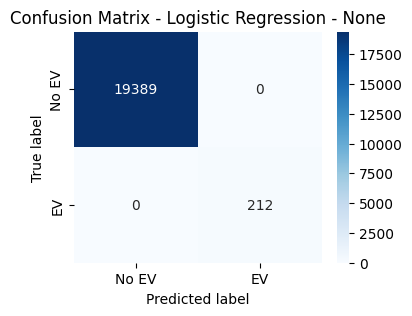

In [166]:
## Analysing with Decision tree algorithm

DT_data = cleaned_data.copy()

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_distributions=param_dist, cv=5, random_state=0)

x = DT_data.drop('EV', axis=1)  
y = DT_data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)
    
X_train, y_train = perform_sampling(X_train, y_train, y_test, 'under')

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 9, 
                                     max_features= 5, min_samples_leaf= 1, 
                                     random_state=0)
Tree.fit(X_train, y_train)
y_pred = Tree.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Tree, x, y)


In [167]:
## Random forest classification

RF_data = cleaned_data.copy()

param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6,7,8,9],
               'max_depth': [1,2,3,4,5,6,7,8,9],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()


x = RF_data.drop('EV', axis=1)  
y = RF_data['EV']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, stratify=y, random_state=42)

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(x, y)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))


Tuned Random Forest Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 5, 'criterion': 'entropy'}


Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19389
           1       1.00      1.00      1.00       212

    accuracy                           1.00     19601
   macro avg       1.00      1.00      1.00     19601
weighted avg       1.00      1.00      1.00     19601


Average 5-Fold CV Score: 1.0 , Standard deviation: 0.0
Accuracy: 1.0
Sensitivity :  1.0
Specificity :  1.0


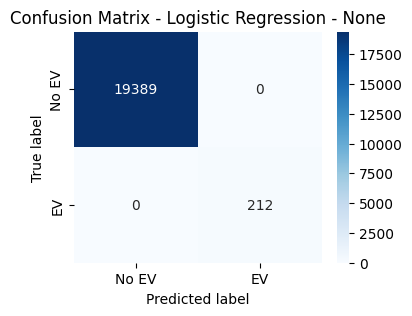

In [169]:
Ran = RandomForestClassifier(criterion= 'entropy', max_depth= 5, 
                                     max_features= 6, n_estimators= 200, 
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

get_metrics(y_pred, X_test, y_test, Ran, x, y)


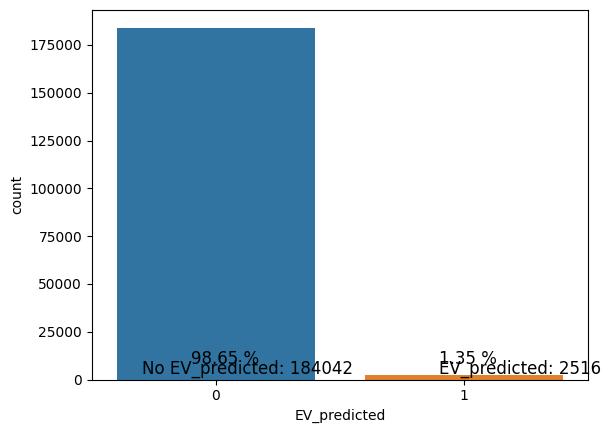

(186558, 19)


In [170]:
predict_and_visualize(Ran,df,  'EV')

In [ ]:
SVM_data = cleaned_data.copy()

x = SVM_data.drop('EV', axis=1)  
y = SVM_data['EV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM_Model = SVC(kernel='linear', C=1.0, class_weight='balanced')

SVM_Model.fit(x,y)

print (f'Accuracy - : {SVM_Model.score(X,y):.3f}')
